In [1]:
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 09:23:15) 
[Clang 10.0.1 (clang-1001.0.46.3)]


In [762]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import requests
import seaborn as sns; sns.set()
from collections import Counter, namedtuple
from lxml import etree

In [558]:
Article = namedtuple('Article', 'pmid title abstract')

In [730]:
def top_k(vec, dictionary, k=20):
    for k,v in sorted(vec, key=lambda x: -x[1])[:k]:
        print(f'{dictionary[k]:>20}   {v}')

# Read abstracts from PubMed API

In [4]:
PMID_XPATH = 'MedlineCitation/PMID/text()'
TITLE_XPATH = 'MedlineCitation/Article/ArticleTitle/text()'
ABSTRACT_XPATH = 'MedlineCitation/Article/Abstract/AbstractText/text()'

In [557]:
filename = '../data/pmids_gold_set_labeled.txt'
labeled_set = pd.read_csv(filename, sep='\t', names=['pmid', 'topic'])

In [558]:
Article = namedtuple('Article', 'pmid title abstract')

In [559]:
def join_text(nodes, delim='\n'):
    return delim.join(nodes) if nodes else ''

In [562]:
def fetch_abstracts(pubmed_ids):
    """
    Fetches abstracts from the Entrez API.

    Returns a dict mapping pubmed ids to abstracts.
    """
    url = ('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
          'efetch.fcgi'
          '?db=pubmed'
          '&retmode=xml'
          '&rettype=abstract'
          '&id={ids}').format(ids=','.join(str(pmid) for pmid in pubmed_ids))

    ## stream XML response into lxml parser
    response = requests.get(url, stream=True)
    root = etree.parse(io.BytesIO(response.content))

    ## extract abstracts for each article
    return [Article(
            pmid = join_text(article.xpath(PMID_XPATH)),
            title = join_text(article.xpath(TITLE_XPATH)),
            abstract = join_text(article.xpath(ABSTRACT_XPATH)),
        )
        for article in root.xpath('PubmedArticle')]

In [563]:
articles = fetch_abstracts(labeled_set.pmid)
print(len(articles))

103


# Look at most common words

In [761]:
import gensim
from gensim import corpora
from gensim import models
from gensim import utils
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string, remove_stopwords
from gensim.models.coherencemodel import CoherenceModel

Convert titles/abstracts into lists of individual words, filtering out stop words

In [565]:
texts = [
    (remove_stopwords(a.title.lower()).split() +
     remove_stopwords(a.abstract.lower()).split())
    for a in articles
]

In [566]:
df = Counter(w for t in texts for w in t)

In [567]:
len(df)

4196

How many words occur more than once in the corpus?

In [568]:
sum(n>1 for w,n in df.items())

1646

In [569]:
df.most_common(20)

[('cystic', 124),
 ('breast', 121),
 ('patients', 115),
 ('cancer', 85),
 ('fibrosis', 84),
 ('clinical', 80),
 ('treatment', 72),
 ('disease', 66),
 ('osteogenesis', 53),
 ('mutations', 51),
 ('genetic', 48),
 ('triple-negative', 47),
 ('expression', 38),
 ('tnbc', 38),
 ('bone', 38),
 ('bbs', 38),
 ('tumor', 37),
 ('type', 36),
 ('gene', 35),
 ('negative', 34)]

In [570]:
print(df['tnbc'],df['(tnbc)'],df['(tnbc),'])

38 12 1


In [571]:
[(w,n) for w,n in df.items() if '-' in w][:10]

[('triple-negative', 47),
 ('er-positive,', 1),
 ('her2-positive', 1),
 ('mir-26b,', 3),
 ('up-regulation', 1),
 ('up-regulated', 1),
 ('over-expression', 1),
 ('up-regulating', 1),
 ('gper-1.', 1),
 ('17β-oestradiol', 1)]

## Preprocess

In [867]:
medical_stopwords = {'patient', 'patients', 'clinical', 'treatment', 'disease',
                     'present', 'new', 'diagnosis', 'disorder', 'disorders', 'associated'}
STOPWORDS = gensim.parsing.preprocessing.STOPWORDS | medical_stopwords

In [868]:
def remove_stopwords(s):
    s = utils.to_unicode(s)
    return " ".join(w for w in s.split() if w not in STOPWORDS)

In [869]:
filters = [
    lambda x: x.lower(),
    gensim.parsing.preprocessing.strip_punctuation,
    gensim.parsing.preprocessing.strip_multiple_whitespaces,
    gensim.parsing.preprocessing.strip_numeric,
    remove_stopwords,
    #strip_short,
    gensim.parsing.preprocessing.stem_text
]

In [870]:
texts = [preprocess_string(a.title + ' ' + a.abstract, filters=filters) for a in articles]

In [871]:
df = Counter(w for t in texts for w in t)

In [872]:
len(df)

2197

In [892]:
for i in range(20):
    print('{:>3} {:4}'.format(i, sum(n>i for w,n in df.items())))

  0 2197
  1 1287
  2  916
  3  697
  4  551
  5  449
  6  389
  7  329
  8  276
  9  241
 10  213
 11  196
 12  179
 13  162
 14  141
 15  133
 16  117
 17  103
 18   93
 19   87


In [874]:
texts = [[w for w in t if (len(w) > 1 and df[w]>3)] for t in texts]

### How many non-filtered words do the texts have?

Text(0, 0.5, 'documents')

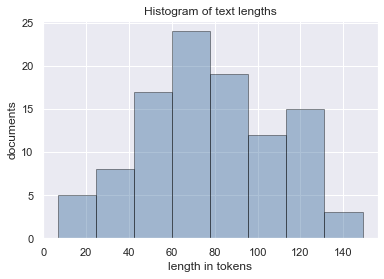

In [875]:
sns.distplot([len(t) for t in texts],
             hist=True, kde=False,
             color = '#336699',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of text lengths')
plt.xlabel('length in tokens')
plt.ylabel('documents')

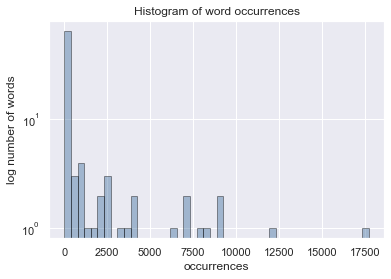

In [964]:
ax = sns.distplot([c for w,c in counts.items()],
                  hist=True, kde=False,
                  color = '#336699',
                  hist_kws={'edgecolor':'black'})

plt.title('Histogram of word occurrences')
plt.xlabel('occurrences')
plt.ylabel('log number of words')
ax.set_yscale('log')

## Add bigrams and trigrams

In [876]:
bigrams = models.Phrases(texts, min_count=3)
trigrams = models.Phrases(bigrams[texts], min_count=3)

In [877]:
texts = [text + [x for x in bigrams[text] if '_' in x]
              + [x for x in trigrams[text] if '_' in x]
         for text in texts]

In [879]:
dictionary = corpora.Dictionary(texts)
bows = [dictionary.doc2bow(text) for text in texts]

## tfidfs

In [839]:
tfidf = models.TfidfModel(dictionary=dictionary, normalize=True)

In [840]:
tfidf_vectors = [tfidf[bow] for bow in bows]

## LDA

In [880]:
from gensim.models.ldamodel import LdaModel

In [881]:
vectors = bows

In [882]:
%%time
n_topics = 6
lda = LdaModel(vectors, id2word=dictionary, num_topics=n_topics,
               alpha='auto', eta='auto',
               iterations=500,
               passes=1000,
               eval_every=1)

CPU times: user 1min 24s, sys: 275 ms, total: 1min 24s
Wall time: 1min 25s


In [883]:
lda.show_topics()

[(0,
  '0.071*"bb" + 0.030*"syndrom" + 0.026*"bardet_biedl" + 0.026*"bardet" + 0.026*"biedl" + 0.015*"genet" + 0.015*"syndrom_bb" + 0.013*"protein" + 0.012*"obes" + 0.011*"defect"'),
 (1,
  '0.042*"tripl_neg" + 0.035*"breast_cancer" + 0.034*"mutat" + 0.022*"breast" + 0.022*"neg" + 0.021*"tripl" + 0.020*"cancer" + 0.014*"mir" + 0.014*"brca" + 0.014*"mir_mir"'),
 (2,
  '0.039*"neurofibromatosi" + 0.030*"nf" + 0.023*"qualiti_life" + 0.015*"report" + 0.014*"neurofibromatosi_type" + 0.014*"qualiti" + 0.012*"case" + 0.012*"includ" + 0.012*"mutat" + 0.012*"spinal_neurofibromatosi"'),
 (3,
  '0.030*"fibrosi" + 0.029*"cystic" + 0.029*"cystic_fibrosi" + 0.017*"imperfecta" + 0.016*"osteogenesi_imperfecta" + 0.016*"osteogenesi" + 0.014*"therapi" + 0.014*"bone" + 0.012*"cf" + 0.011*"oi"'),
 (4,
  '0.070*"breast_cancer" + 0.043*"tripl_neg" + 0.040*"cancer" + 0.036*"breast" + 0.024*"neg" + 0.024*"tnbc" + 0.022*"tripl" + 0.018*"cell" + 0.015*"tumor" + 0.013*"receptor"'),
 (5,
  '0.029*"fibrosi" + 0.02

In [884]:
dtm = np.array([
    [dict(lda.get_document_topics(v)).get(topic, 0.0) for topic in range(n_topics)]
    for v in vectors
])

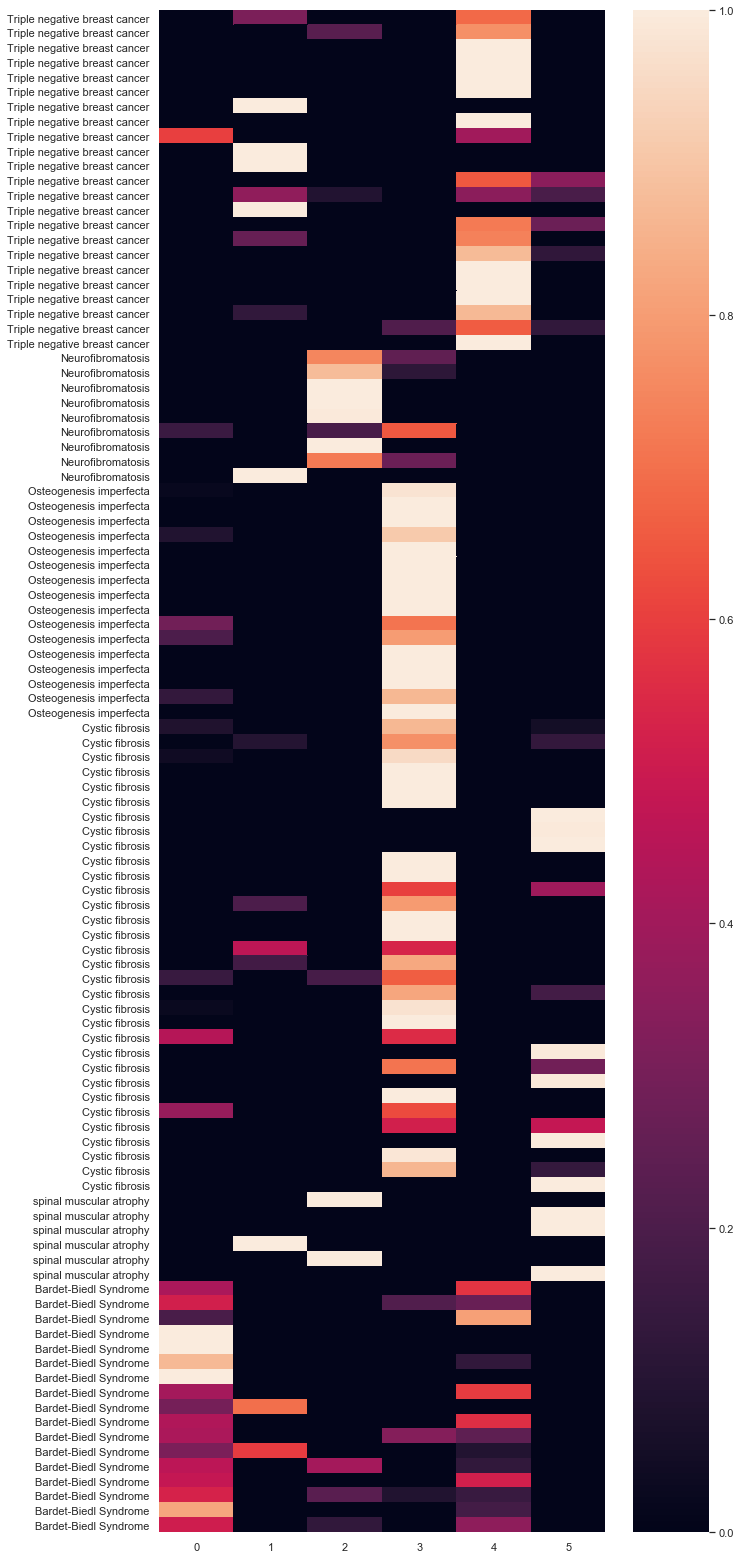

In [885]:
fig, ax = plt.subplots(figsize=(10,28))
ax = sns.heatmap(dtm, vmin=0, vmax=1, ax=ax, yticklabels=labeled_set.topic)

## Coherence measure

In [886]:
coherence_model_lda = CoherenceModel(model=lda,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.42666189035431556


## Parameter sweep

In [929]:
texts = [preprocess_string(a.title + ' ' + a.abstract, filters=filters) for a in articles]
tfc = Counter(w for t in texts for w in t)

In [933]:
def fit_with_params(min_occur, iterations, passes, texts, tfc):

    bigrams = models.Phrases(texts, min_count=3)
    trigrams = models.Phrases(bigrams[texts], min_count=3)

    texts = [[w for w in t if (len(w)>1 and tfc[w]>min_occur)] for t in texts]

    texts = [text + [x for x in bigrams[text] if '_' in x]
                  + [x for x in trigrams[text] if '_' in x]
             for text in texts]

    dictionary = corpora.Dictionary(texts)
    bows = [dictionary.doc2bow(text) for text in texts]

    n_topics = 6
    lda = LdaModel(bows, id2word=dictionary, num_topics=n_topics,
                   alpha='auto', eta='auto',
                   iterations=iterations,
                   passes=passes,
                   eval_every=1)

    coherence_model_lda = CoherenceModel(model=lda,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    return lda, coherence_model_lda.get_coherence()

In [897]:
[(min_occur, iterations, passes, fit_with_params(min_occur, iterations, passes))
    for min_occur in [1,2,3,7,10,17]
        for iterations in [20, 100, 200, 400]
            for passes in [100, 200, 500, 1000, 1500, 2000]
                for rep in range(3)]

[(1, 20, 100, 0.444718990425453),
 (1, 20, 100, 0.4972860461941318),
 (1, 20, 100, 0.42844851763009717),
 (1, 20, 200, 0.5268520125799199),
 (1, 20, 200, 0.45258293040939196),
 (1, 20, 200, 0.5553271990474004),
 (1, 20, 500, 0.5561260527328787),
 (1, 20, 500, 0.5210437967529039),
 (1, 20, 500, 0.5867538928881323),
 (1, 20, 1000, 0.5465537226087677),
 (1, 20, 1000, 0.5625521310134749),
 (1, 20, 1000, 0.5487097928763908),
 (1, 20, 1500, 0.5804820215258338),
 (1, 20, 1500, 0.5281251078932819),
 (1, 20, 1500, 0.551892895355298),
 (1, 20, 2000, 0.5418355311536075),
 (1, 20, 2000, 0.5737940649598842),
 (1, 20, 2000, 0.535933063588935),
 (1, 100, 100, 0.5304695413551856),
 (1, 100, 100, 0.4326433617212076),
 (1, 100, 100, 0.5554006288538174),
 (1, 100, 200, 0.5685265327084345),
 (1, 100, 200, 0.5135455160717797),
 (1, 100, 200, 0.46634868388095296),
 (1, 100, 500, 0.5568912790809403),
 (1, 100, 500, 0.567875120219462),
 (1, 100, 500, 0.5264414354424876),
 (1, 100, 1000, 0.549821218969095),
 (

In [900]:
a = _897

In [906]:
coh = pd.DataFrame(a, columns=['min-occur', 'iterations', 'passes', 'coherence'])
coh.shape

(432, 4)

In [912]:
coh.head()

,min-occur,iterations,passes,coherence
0,1,20,100,0.444719
1,1,20,100,0.497286
2,1,20,100,0.428449
3,1,20,200,0.526852
4,1,20,200,0.452583


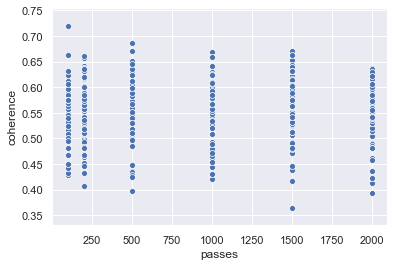

In [908]:
ax = sns.scatterplot(x="passes", y="coherence", data=coh)

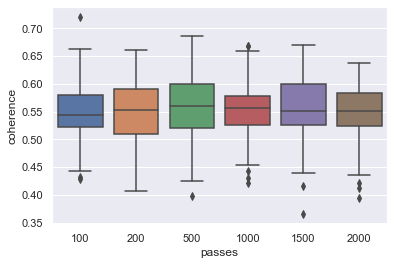

In [909]:
ax = sns.boxplot(x="passes", y="coherence", data=coh)

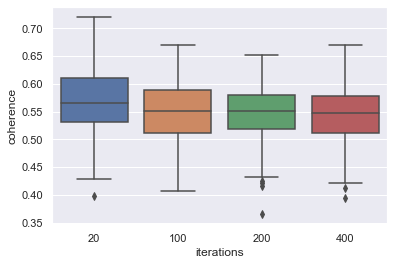

In [910]:
ax = sns.boxplot(x="iterations", y="coherence", data=coh)

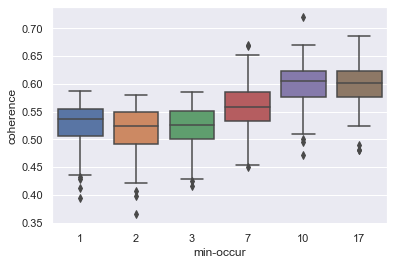

In [911]:
ax = sns.boxplot(x="min-occur", y="coherence", data=coh)

In [914]:
from tqdm import tqdm

In [915]:
params = [(m,i,p) 
          for m in [8,12,16,20]
              for i in [10,20,30,40,50]
                  for p in [100, 200, 400, 500, 600, 800]
                     for rep in range(3)]
len(params)

360

In [916]:
a2 = [(m, i, p, fit_with_params(min_occur=m, iterations=i, passes=p))
        for m,i,p in tqdm(params)]

100%|██████████| 360/360 [2:58:24<00:00, 46.00s/it]   


In [917]:
coh = pd.DataFrame(a2, columns=['min-occur', 'iterations', 'passes', 'coherence'])
coh.shape

(360, 4)

In [918]:
coh.head()

,min-occur,iterations,passes,coherence
0,8,10,100,0.647258
1,8,10,100,0.637566
2,8,10,100,0.574876
3,8,10,200,0.612044
4,8,10,200,0.565133


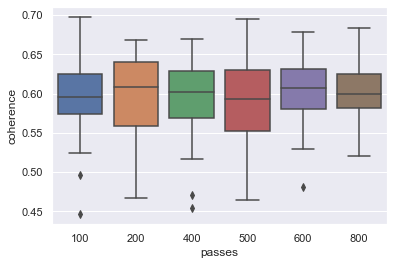

In [919]:
ax = sns.boxplot(x="passes", y="coherence", data=coh)

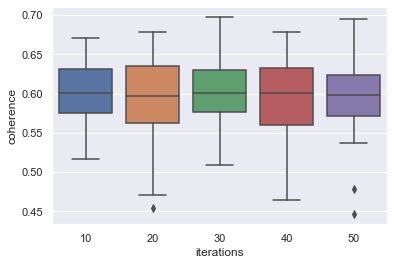

In [920]:
ax = sns.boxplot(x="iterations", y="coherence", data=coh)

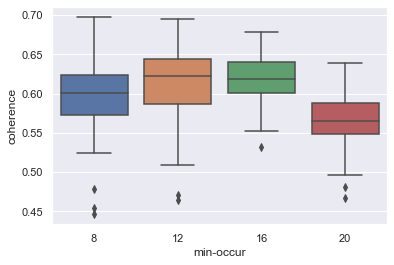

In [921]:
ax = sns.boxplot(x="min-occur", y="coherence", data=coh)

In [934]:
m = 16
i = 10
p = 300
a3 = [(m, i, p, fit_with_params(min_occur=m, iterations=i, passes=p, texts=texts, tfc=tfc))
        for _ in tqdm(range(10))]


100%|██████████| 10/10 [02:51<00:00, 17.38s/it]

In [936]:
max_coh = 0.0
a_max = None
for a_i in a3:
    if a_i[3][1] > max_coh:
        a_max = a_i
        max_coh = a_i[3][1]

## sklearn, tf-idf, k-means

In [983]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [965]:
texts = [a.title + ' ' + a.abstract for a in articles]

In [1005]:
vectorizer = TfidfVectorizer(max_df=0.66,
                             max_features=1000,
                             min_df=2,
                             stop_words='english')
X = vectorizer.fit_transform(texts)

In [1006]:
X.shape

(103, 1000)

In [1011]:
km = KMeans(n_clusters=6,
            init='random',
            max_iter=100,
            n_init=20,
            verbose=True)

In [1012]:
km.fit(X)

Initialization complete
Iteration  0, inertia 160.848
Iteration  1, inertia 81.824
Iteration  2, inertia 80.357
Iteration  3, inertia 78.548
Iteration  4, inertia 77.570
Iteration  5, inertia 77.450
Iteration  6, inertia 77.327
Iteration  7, inertia 77.245
Converged at iteration 7: center shift 0.000000e+00 within tolerance 9.206511e-08
Initialization complete
Iteration  0, inertia 151.149
Iteration  1, inertia 77.294
Iteration  2, inertia 76.927
Iteration  3, inertia 76.725
Iteration  4, inertia 76.559
Iteration  5, inertia 76.410
Iteration  6, inertia 76.273
Converged at iteration 6: center shift 0.000000e+00 within tolerance 9.206511e-08
Initialization complete
Iteration  0, inertia 158.226
Iteration  1, inertia 84.266
Iteration  2, inertia 83.507
Iteration  3, inertia 83.204
Converged at iteration 3: center shift 0.000000e+00 within tolerance 9.206511e-08
Initialization complete
Iteration  0, inertia 147.249
Iteration  1, inertia 78.532
Iteration  2, inertia 77.677
Iteration  3, in

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=100, n_clusters=6,
       n_init=20, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=True)

In [1013]:
km.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [1014]:
pd.DataFrame(dict(true_label=labeled_set.topic, km_label=km.labels_))

,true_label,km_label
0,Triple negative breast cancer,0
1,Triple negative breast cancer,0
2,Triple negative breast cancer,0
3,Triple negative breast cancer,0
4,Triple negative breast cancer,0
5,Triple negative breast cancer,0
6,Triple negative breast cancer,0
7,Triple negative breast cancer,0
8,Triple negative breast cancer,0
9,Triple negative breast cancer,0


In [990]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199